# Tutorial 4: Initializing a small-scale chain

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gstatsMCMC import Topography
from gstatsMCMC import MCMC
import gstatsim as gs
from sklearn.preprocessing import QuantileTransformer
import skgstat as skg

In [126]:
# load compiled bed elevation measurements
df = pd.read_csv('DenmanDataGridded.csv')

In [127]:
rng_seed = 81978947

In [128]:
# create a grid of x and y coordinates
x_uniq = np.unique(df.x)
y_uniq = np.unique(df.y)

xmin = np.min(x_uniq)
xmax = np.max(x_uniq)
ymin = np.min(y_uniq)
ymax = np.max(y_uniq)

cols = len(x_uniq)
rows = len(y_uniq)

resolution = 500

xx, yy = np.meshgrid(x_uniq, y_uniq)

In [129]:
# load other data
dhdt = df['dhdt'].values.reshape(xx.shape)
smb = df['smb'].values.reshape(xx.shape)
velx = df['velx'].values.reshape(xx.shape)
vely = df['vely'].values.reshape(xx.shape)
bedmap_mask = df['bedmap_mask'].values.reshape(xx.shape)
bedmachine_thickness = df['bedmachine_thickness'].values.reshape(xx.shape)
bedmap_surf = df['bedmap_surf'].values.reshape(xx.shape)
highvel_mask = df['highvel_mask'].values.reshape(xx.shape)
bedmachine_bed = df['bedmap_surf'].values.reshape(xx.shape) - bedmachine_thickness
bedmap_bed = df['bedmap_bed'].values.reshape(xx.shape)

In [130]:
# create conditioning data
# bed elevation measurement in grounded ice region, and bedmap topography elsewhere
cond_bed = np.where(bedmap_mask == 1, df['bed'].values.reshape(xx.shape), bedmap_bed)
df['cond_bed'] = cond_bed.flatten()

# create a mask of conditioning data
data_mask = ~np.isnan(cond_bed)

(2200000.0, 2600000.0, -500500.0, -300500.0)

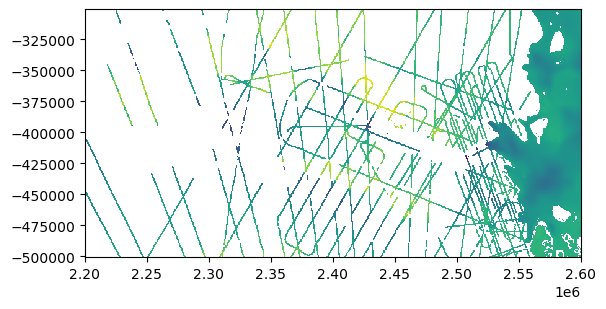

In [44]:
plt.pcolormesh(xx,yy,cond_bed)
plt.axis('scaled')

__step1: calculate the trend__

For small scale chain, we want to simulate small scale topographic features using Sequential Gaussian Simulation. Here, we load the topography from the end of the large scale chain (initial_bed) and smooth this topography to obtain the trend.

In [131]:
initial_bed = np.loadtxt('Denman_bed_599000.txt')

In [132]:
thickness = bedmap_surf - initial_bed
np.where((thickness<=0)&(bedmap_mask==1))

(array([], dtype=int64), array([], dtype=int64))

In [133]:
import scipy as sp
trend = sp.ndimage.gaussian_filter(initial_bed, sigma=10)

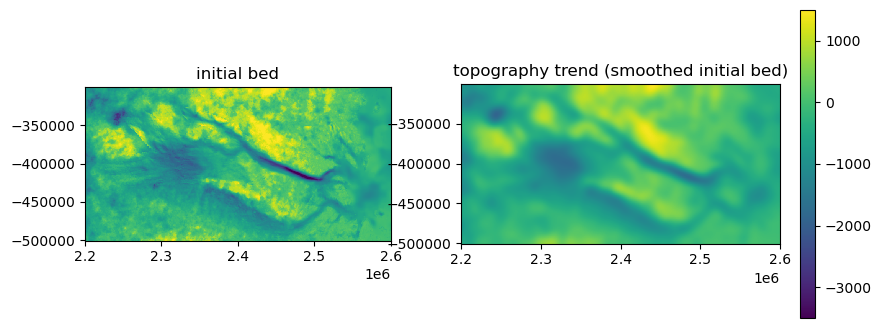

In [134]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4),gridspec_kw={'width_ratios': [1, 1.3]} )

axes[0].pcolormesh(xx, yy, initial_bed, vmax=1500,vmin=-3500)
axes[0].set_title('initial bed')
axes[0].set_aspect('equal')

bedfig = axes[1].pcolormesh(xx, yy, trend, vmax=1500,vmin=-3500)
axes[1].set_title('topography trend (smoothed initial bed)')
axes[1].set_aspect('equal')
fig.colorbar(bedfig, ax=axes[1])

__step2: calculate the variogram__

Here, there are multiple options to SGS. SGS in my experience works best with detrending (subtracting the trend from the bed topography to obtain small-scale variations) and normalization (project the distribution of bed elevation into a normal distribution). 

The default code here showcase a chain with both detrending and normalization. A chain with no detrending is presented in the comment.

In [135]:
# ##################WHEN NO DETREND###################
# #normalize the conditioning bed data, saved to df['Nbed']
# data = df['cond_bed'].values.reshape(-1,1)
# nst_trans = QuantileTransformer(n_quantiles=1000, output_distribution="normal",subsample=None,random_state=rng_seed).fit(data)
# transformed_data = nst_trans.transform(data)
# df['Nbed'] = transformed_data

In [181]:
# normalize the conditioning bed data, saved to df['Nbed']
df['cond_bed_residual']=df['cond_bed'].values-trend.flatten()
data = df['cond_bed_residual'].values.reshape(-1,1)

# data used to evaluate the distribution. We use all data in the initial bed
data_for_distribution = (initial_bed - trend).reshape((-1,1))
nst_trans = QuantileTransformer(n_quantiles=1000, output_distribution="normal",subsample=None,random_state=rng_seed).fit(data_for_distribution)

# normalize all data in df['cond_bed_residual']
transformed_data = nst_trans.transform(data)
df['Nbed_residual'] = transformed_data

In [138]:
# ###################WHEN NO DETREND###################

# # randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
# df_sampled = df.sample(frac=0.5, random_state=rng_seed)
# df_sampled = df_sampled[df_sampled["cond_bed"].isnull() == False]
# df_sampled = df_sampled[df_sampled["bedmap_mask"]==1]

# # compute experimental (isotropic) variogram
# coords = df_sampled[['x','y']].values
# values = df_sampled['Nbed']

# maxlag = 20000      # maximum range distance
# n_lags = 70         # num of bins (try decreasing if this is taking too long)

# # compute variogram
# V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False, model='matern')

# # extract variogram values
# xdata = V1.bins
# ydata = V1.experimental

# V1_p = V1.parameters

# # evaluate models
# xi = np.linspace(0, xdata[-1], n_lags) 
# y_mtn = [skg.models.matern(h, V1_p[0], V1_p[1], V1_p[2], V1_p[3]) for h in xi]
# # variogram parameter is [range, sill, shape, nugget] for matern model.

# plt.figure(figsize=(6,4))
# plt.scatter(xdata, ydata, s=12, c='g')
# plt.plot(xi, y_mtn,'b-.', label='Matern variogram model')
# plt.title('Isotropic Experimental Variogram')
# plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
# plt.show()

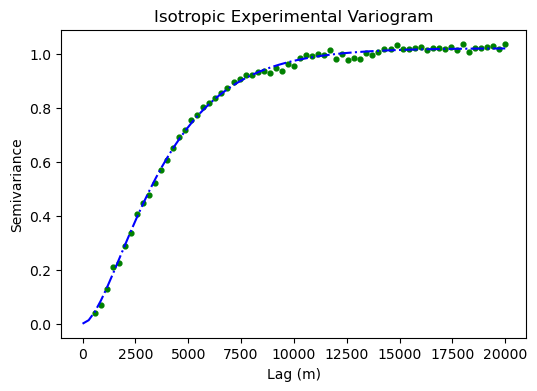

In [183]:
# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.5, random_state=rng_seed)
df_sampled = df[df["cond_bed_residual"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"]==1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['Nbed_residual']

maxlag = 20000      # maximum range distance
n_lags = 70         # num of bins (try decreasing if this is taking too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', 
                   n_lags=n_lags, maxlag=maxlag, normalize=False, 
                   model='matern')

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

# Notice: because we randomly drop out some data, the calculation of V1_p won't always obtain the same result
# To ensure reproducibility of your work, please use a consistent set of V1_p throughout different chains
V1_p = V1.parameters

# evaluate models
xi = np.linspace(0, xdata[-1], n_lags) 
y_mtn = [skg.models.matern(h, V1_p[0], V1_p[1], V1_p[2], V1_p[3]) for h in xi]
# variogram parameter is [range, sill, shape, nugget] for matern model.

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.plot(xi, y_mtn,'b-.', label='Matern variogram model')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

In [184]:
V1_p

[9932.545836561178, 1.021964658501033, 1.2259010610301213, 0]

I recommend to find the variogram parameters (V1_p) once and keep using it with all the chains you run in this region.

save the value for later documentation purpose

In [48]:
V1_p = [9932.545836561178, 1.021964658501033, 1.2259010610301213, 0]

In [185]:
###################When load sgs-generated bed as initial bed###################
# #load the initial bed, make sure no bed in grounded ice region is higher altitude than ice surface
# sgs_bed = np.loadtxt('sgs_bed_totten_cropped.txt')
# thickness = bedmap_surf - sgs_bed
# sgs_bed = np.where((thickness<=0)&(bedmap_mask==1), bedmap_surf-1, sgs_bed)

### Then initiating the small scale chain

The first 4 initialization process are very similar to chain_crf, please refers to Tutorial 3 for detailed information

Some functions specific for small scale chain: We can set up normal score transformation using 'set_normal_transformation' and set up the trend using 'set_trend'.

In the comment, code for not using detrending or/and normalization is presented. Notice that if you don't use normalization, then the variogram parameter must be calculated on radar measurement that is not normalized

In [186]:
grounded_ice_mask = (bedmap_mask == 1)

In [188]:
smallScaleChain = MCMC.chain_sgs(xx, yy, initial_bed, bedmap_surf, velx, vely, dhdt, smb, cond_bed, data_mask, grounded_ice_mask, resolution)

before running the chain, please set where the block update will be using the object's function set_update_in_region(region_mask) and set_update_region(update_in_region)
please also set up the sgs parameters using set_sgs_param(self, block_size, sgs_param)
then please set up the loss function using either set_loss_type or set_loss_func


In [189]:
smallScaleChain.set_update_region(True,highvel_mask)

the update blocks is set to be randomly generated for any locations inside the given region


In [190]:
smallScaleChain.set_loss_type(sigma_mc=5, massConvInRegion=True)

In [191]:
# set up the block sizes
min_block_x = 5
max_block_x = 20
min_block_y = 5
max_block_y = 20
smallScaleChain.set_block_sizes(min_block_x, max_block_x, min_block_y, max_block_y)

Sequential Gaussian Simulation is set to perform on the normalized data. This nst_trans is an object of the QuantileTranformer class in scikit-learn python library. The *fit_variogram* function returns a nst_trans object, which could be directly used here

In [192]:
###################When no normal score transformation###################
# do_transform could be set to true for both detrend and no detrend options
# recommend to set it to true
#smallScaleChain.set_normal_transformation(nst_trans, do_transform=False)

In [193]:
smallScaleChain.set_normal_transformation(nst_trans, do_transform=True)

When running the SGS chain, it is possible to 'detrend' the topography.

Detrend topography refers to substracting a pre-defined trend from the topography map, where the trend suppose to represent long-wavelength features that violate stationary properties of SGS. If choose to detrend the topography, the argument *detrend_map* need to be set to True, and the argument *trend* need to be a 2D numpy array representing the topography trend

In [194]:
###################WHEN NO DETREND###################
#smallScaleChain.set_trend(trend = [], detrend_map = False)

In [195]:
smallScaleChain.set_trend(trend = trend, detrend_map = True)

The 'set_variogram()' and 'set_sgs_param()' functions pass in argument used for SGS simulations

In [196]:
smallScaleChain.set_variogram('Matern',V1_p[0],V1_p[1],0,isotropic=True,vario_smoothness=V1_p[2])

the variogram is set to type Matern


In [197]:
smallScaleChain.set_sgs_param(48, 30e3, sgs_rand_dropout_on=False)

because the sgs_rand_dropout_on is set to False, the dropout_rate is automatically set to 0


__step4: run the chain__

In [198]:
smallScaleChain.set_random_generator(rng_seed = rng_seed)

In [199]:
n_iter = 100
n_segment = 5

for i in range(0,n_segment):
    beds, loss_mc, loss_data, loss, steps, resampled_times, blocks_used = smallScaleChain.run(n_iter=100, info_per_iter=10, only_save_last_bed=False, plot=False, progress_bar=False)
    
    # save all the data in every run of the algorithm
    np.savetxt('Denman_sgs_loss_'+str(i*n_iter)+'.txt', loss)
    np.savetxt('Denman_sgs_steps_'+str(i*n_iter)+'.txt', steps) 
    np.savetxt('Denman_sgs_beds_'+str(i*n_iter)+'.txt',beds.reshape((n_iter, beds.shape[1]*beds.shape[2])))
    
    # set up the next chain
    smallScaleChain.initial_bed = beds[-1,:,:]

i: 0 mc loss: 9.845e+05 loss: 9.845e+05 acceptance rate: 0.0
i: 10 mc loss: 9.845e+05 loss: 9.845e+05 acceptance rate: 0.0
i: 20 mc loss: 9.845e+05 loss: 9.845e+05 acceptance rate: 0.047619047619047616
i: 30 mc loss: 9.843e+05 loss: 9.843e+05 acceptance rate: 0.12903225806451613
i: 40 mc loss: 9.838e+05 loss: 9.838e+05 acceptance rate: 0.17073170731707318
i: 50 mc loss: 9.838e+05 loss: 9.838e+05 acceptance rate: 0.13725490196078433
i: 60 mc loss: 9.838e+05 loss: 9.838e+05 acceptance rate: 0.13114754098360656
i: 70 mc loss: 9.837e+05 loss: 9.837e+05 acceptance rate: 0.14084507042253522
i: 80 mc loss: 9.837e+05 loss: 9.837e+05 acceptance rate: 0.1728395061728395
i: 90 mc loss: 9.831e+05 loss: 9.831e+05 acceptance rate: 0.1978021978021978
i: 0 mc loss: 9.831e+05 loss: 9.831e+05 acceptance rate: 1.0
i: 10 mc loss: 9.828e+05 loss: 9.828e+05 acceptance rate: 0.36363636363636365
i: 20 mc loss: 9.824e+05 loss: 9.824e+05 acceptance rate: 0.3333333333333333
i: 30 mc loss: 9.823e+05 loss: 9.823e+